## Leeds League History
After Leeds' return to the Premier League in 2020, I decided that I wanted to plot their final league positions after each season since the formation of the Premier League. Wikipedia has a list of the league positions for each season [here](https://en.wikipedia.org/wiki/List_of_Leeds_United_F.C._seasons) so I decided to build a scraper that pulls this information and stores as a csv for me to easily read in for the visual. 

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re 

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_Leeds_United_F.C._seasons"
html = requests.get(url).text 
soup = BeautifulSoup(html, features="html.parser")

In [3]:
tables = soup.find_all(class_='wikitable')

In [4]:
header_rows = tables[0].find_all('tr')[:2]
data_rows = tables[0].find_all('tr')[2:]

The table that we are trying to scrape here isn't the most regular and contains some rows that have 'sub-rows' and double cells, so I'm going to define some helper functions to work on being able to pull the information that we need from the rows that we have looped through and found. 

In [5]:
def find_season(data_row):
    """
    Given a data row, return the season for that row
    """
    return re.search(r'(\d\d\d\d.{1}\d\d).*', data_row.find('th').text).group(1)

def find_data_values(data_row):
    """
    Find headers to match the header in each row 
    """
    return [x.text.replace('\n', '') for x in data_row.find_all('td')]

def find_division(data_row):
    """
    For a given cleaned data row, take the first element, the division
    """
    return data_row[0]

def find_position(data_row):
    """
    For a given cleaned data row, take the ninth element, the final position for that season
    """
    return data_row[8]

Due to the format of the table, we have to do some manual intervention here because `data_rows[72]` is a sub row for the same year that is started by `data_rows[71]`. This is because in that year there are 2 cells required for the 'Europe/Other' category as Leeds played in the FA Charity Shield and the Champions League. For the time being, I will manually declare the rows and as we don't need that information. 

In [6]:
# Show the partial row for reference 
[x.text.replace('\n','') for x in data_rows[71:73]]

['1992–93Prem[l]4212151557625117thR4R3FA Charity ShieldWLee Chapman1727,585',
 'Champions LeagueR2']

In [7]:
# As discussed, I have removed the sub row for easier processing of our elements 
relevant_data_rows = [data_rows[71]] + data_rows[73:]

In [8]:
# Pull the seasons for the ones that we are interested in
seasons = [find_season(data_rows[71])] + [find_season(x) for x in data_rows[73:]]

In [9]:
# Use the helper function to pull the values, and isolate the ones we are interested in
data_values = [find_data_values(x) for x in relevant_data_rows]
divisions = [find_division(x) for x in data_values]
positions = [find_position(x) for x in data_values]

In [10]:
# Store data as a dictionary for conversion
data_dict = {
    'season': seasons, 
    'division': divisions, 
    'position': positions
}

# Format as a data frame
pd.DataFrame(data_dict)

,season,division,position
0,1992–93,Prem[l],17th
1,1993–94,Prem,5th
2,1994–95,Prem,5th
3,1995–96,Prem,13th
4,1996–97,Prem,11th
5,1997–98,Prem,5th
6,1998–99,Prem,4th
7,1999–20,Prem,3rd
8,2000–01,Prem,4th
9,2001–02,Prem,5th


We are almost at the stage that we have all the data that we need. We just need to do some more cleaning and add some additional columns. 
1. Remove the reference brackets that provide extra information on the site
2. Remove the suffix for the date and store that (in case we want to use it later)
3. Add a column to indicate the number of teams in the league

In [30]:
def remove_ref_brackets(str):
    # If a reference exists, take the part before it 
    if '[' in str:
        pattern_str = "(.*)\[[a-z]{1}\]" 
        pattern = re.compile(pattern_str)
        return re.search(pattern, str).group(1)
    else:
        return str

def separate_position_suffix(str):
    pattern_str = "(\d{1,2})([a-z]{2})"
    pattern = re.compile(pattern_str)
    return {'position': re.search(pattern, str).group(1), 
            'suffix': re.search(pattern, str).group(2)}

In [31]:
clean_divisions = [remove_ref_brackets(x) for x in divisions]
clean_positions = [remove_ref_brackets(x) for x in positions]
separated_positions = [separate_position_suffix(x) for x in clean_positions]

In [38]:
# Update dict for clean columns
data_dict = {
    'season': seasons, 
    'division': clean_divisions,
    'position_dict': separated_positions
}

# Format as a data frame
df = pd.DataFrame(data_dict)
df = pd.concat([df.loc[:,['season', 'division']], 
           df.position_dict.apply(pd.Series)], sort=False, axis = 1)

division_total_teams = {'Prem': 20, 'Champ': 24, 'Lge 1': 24}
df["division_total_teams"] = df.division.map(division_total_teams)

In [40]:
df

,season,division,position,suffix,division_total_teams
0,1992–93,Prem,17,th,20
1,1993–94,Prem,5,th,20
2,1994–95,Prem,5,th,20
3,1995–96,Prem,13,th,20
4,1996–97,Prem,11,th,20
5,1997–98,Prem,5,th,20
6,1998–99,Prem,4,th,20
7,1999–20,Prem,3,rd,20
8,2000–01,Prem,4,th,20
9,2001–02,Prem,5,th,20


In [43]:
df.to_csv('../output/leeds_league_history.csv', index=False)

In [44]:
df

,season,division,position,suffix,division_total_teams
0,1992–93,Prem,17,th,20
1,1993–94,Prem,5,th,20
2,1994–95,Prem,5,th,20
3,1995–96,Prem,13,th,20
4,1996–97,Prem,11,th,20
5,1997–98,Prem,5,th,20
6,1998–99,Prem,4,th,20
7,1999–20,Prem,3,rd,20
8,2000–01,Prem,4,th,20
9,2001–02,Prem,5,th,20


In [45]:
import matplotlib.pyplot as plt

In [51]:
df['position'] = pd.to_numeric(df["position"])

In [62]:
df["y_position"] = (df.division_total_teams - df.position + 1) 
df["y_base"] = df.division.map({'Prem': 48, 'Champ': 24, 'Lge 1': 0})
df["y"] = df.y_position + df.y_base
df.drop(['y_position', 'y_base'], axis=1, inplace=True)
df.sort_values('y') # Check that the logic works and that lower numbers mean lower position overall 

,season,division,position,suffix,division_total_teams,y
15,2007–08,Lge 1,5,th,24,20
16,2008–09,Lge 1,4,th,24,21
17,2009–10,Lge 1,2,nd,24,23
14,2006–07,Champ,24,th,24,25
22,2014–15,Champ,15,th,24,34
21,2013–14,Champ,15,th,24,34
19,2011–12,Champ,14,th,24,35
12,2004–05,Champ,14,th,24,35
25,2017–18,Champ,13,th,24,36
23,2015–16,Champ,13,th,24,36


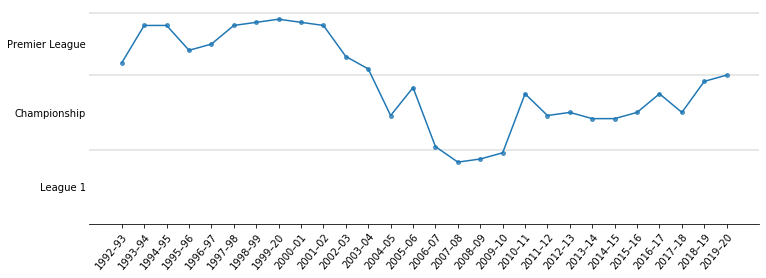

In [101]:
fig, ax = plt.subplots(figsize = (12, 4))

# Add lines and points
ax.plot(df.season, df.y, zorder=100)
ax.scatter(df.season, df.y, s=15, alpha=0.75)

# Hard code the limits 
ax.set_ylim(0, 70)

# Add lines to separate out the leagues
ax.axhline(24, zorder=-1, c='grey', alpha=0.25)
ax.axhline(48, zorder=-1, c='grey', alpha=0.25)
ax.axhline(68, zorder=-1, c='grey', alpha=0.25)

# Make the xtick labels legible
plt.xticks(rotation=50, ha='right', rotation_mode="anchor")

# Remove the spines to clear up the visual 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add league markers in the middle of the band for that league 
ax.set_yticks([12, 36, 58])
ax.set_yticklabels(['League 1', 'Championship', 'Premier League'])

# Remove y tick markers 
ax.tick_params(axis='y', which='both', length=0)

plt.show()